---

# Proyecto 1: Hack a Boss
## Análisis del Top 10 ETFs

Proyecto de análisis del Top 10 de ETFs.

### Documentación del Proyecto

1. [Presentación Paula](https://docs.google.com/presentation/d/1Wk4tVhK89EP7b4iiIhvcTk4n5uHJkxgnuADb6Dk_Nto/edit?usp=sharing)

---





# Importación de **librerías**
### Incluid aquí las librerías a instalar e importar

In [1]:
# Instalar las librerías
%pip install matplotlib
%pip install seaborn
%pip install yfinance
%pip install yahooquery
%pip install airtable-python-wrapper

In [3]:
# Importar las librerías
import time
import requests
import warnings
import numpy as np
import yfinance as yf
import yahooquery as yq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from pprint import pprint
import airtable
from tqdm import tqdm
warnings.filterwarnings("ignore")

# Sección Extracción de datos (API y WebScraping)





In [41]:
HEADERS = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

def seleccion_etf(tipo_etfs:str, num:int) -> list:
    # Obtención de los símbolos del Top ETFs de EEUU
    s = yq.Screener()
    dict_query = s.get_screeners(tipo_etfs, num)
    tickers = [symbol['symbol'] for symbol in dict_query[tipo_etfs]['quotes']]
    return tickers

def corregir_nombres_columnas(df_columns:pd.Index) -> pd.Index:
    # Eliminar caracteres especiales
    df_columns = df_columns.str.replace('[^\w\s]', '', regex=True)
    # Sustituir espacios por _
    df_columns = df_columns.str.replace(' ', '_')
    # Retornar el DF
    return(df_columns)

def convertir_a_indexado(df):
    # Resetear índice
    df_reset = df.reset_index()
    # Convertir el dataframe a formato largo
    df_melted = df_reset.melt(id_vars='Date', var_name=['Attribute', 'Ticker'], value_name='Value')
    # Una columna para cada cosa
    df_melted['Attribute'] = df_melted['Attribute'].astype(str)
    df_pivoted = df_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='Value').reset_index()
    # Ponerlo todo bien y en orden
    df_pivoted.columns.name = None
    df_pivoted = df_pivoted[['Date', 'Ticker', 'Adj Close', 'Volume']]
    df_pivoted = df_pivoted.rename(
        columns={
            'Date':'Fecha',
            'Ticker':'Ticker',
            'Adj Close':'Precio',
            'Volume':'Volumen'
            }
        )
    # Retornar dataframe
    return df_pivoted

def down_price_vol(tickers:list) -> pd.DataFrame:
    # Descarga de las cotizaciones
    df = yf.download(tickers, period='max')
    # Obtener los nombres de las columnas para 'Adj Close' y 'Volume'
    adj_close_cols = [('Adj Close', ticker) for ticker in tickers]
    volume_cols = [('Volume', ticker) for ticker in tickers]

    # Seleccionar las columnas de interés
    df = df[adj_close_cols + volume_cols]
    # Eliminar valores nulos y cambiar los precios por incrementos porcentuales
    df = df.dropna().pct_change(1).dropna()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    # Retornar DataFrame
    return(df)

def web_scraping_sectors(tickers:list) -> pd.DataFrame:
    url_base = "https://es.finance.yahoo.com/quote/"
    lista_sectores = [
        "Materiales básicos", "Acciones cíclicas", "Servicios financieros",
        "Propiedades inmobiliarias", "Acciones defensivas", "Atención sanitaria",
        "Utilidades", "Servicios de comunicación", "Energía", "Industriales",
        "Tecnología"
    ]
    dict_sectores = {}
    for etf in tqdm(tickers):
        url = f'{url_base}{etf}/holdings?p={etf}'
        response = requests.get(
            url,
            headers = HEADERS
            )
        soup = BeautifulSoup(response.text, 'html.parser')
        sectores_etf = {}
        lista_contenedores = soup.findAll('div', class_='Bdbw(1px) Bdbc($seperatorColor) Bdbs(s) H(25px) Pt(10px)')
        for item in lista_contenedores:
            sector = item.find('span', class_='Mend(5px) Whs(nw)').text
            if sector in lista_sectores:
                valor = item.find('span', class_='W(20%) D(b) Fl(start) Ta(e)').text
                sectores_etf[sector] = valor
        dict_sectores[etf] = sectores_etf
    # Convertir diccionario en dataframe
    df = pd.DataFrame.from_dict(dict_sectores).T
    # Convertir todas las entradas a strings, eliminar el '%' y reemplazar comas por puntos
    df = df.map(lambda x: str(x).replace('%', '').replace(',', '.'))
    # Convertir las cadenas a números flotantes y dividir por 100 para tener los porcentajes en formato decimal
    df = df.map(lambda x: float(x) / 100.0 if x != 'N/A' else 0)
    # Quitar los espacios
    df.columns = corregir_nombres_columnas(df.columns)
    # Resetear índice
    df = df.reset_index()
    df = df.rename(columns={'index':'Ticker'})
    # Retornar DataFrame
    return (df)

def tabla_net_assets(tickers:list) -> pd.DataFrame:
    def convertir_valor(valor):
        if 'M' in valor:
            return float(valor.replace('M', ''))
        elif 'B' in valor:
            return float(valor.replace('B', '')) * 1000
        else:
            return float(valor)
    #Net assets table
    net_assets = pd.DataFrame()
    for ticker in tqdm(tickers):
        url = f"https://finance.yahoo.com/quote/{ticker}?p={ticker}"
        response = requests.get(url, headers=HEADERS)
        try:
            tables = pd.read_html(response.text)
            for table in tables:
                labels_to_remove = ["Previous Close", "Open", "Bid", "Ask", "Day's Range", "52 Week Range", "Volume","Avg. Volume"]
                table = table[~table.iloc[:, 0].isin(labels_to_remove)]
                data_series = pd.Series(dict(zip(table.iloc[:, 0], table.iloc[:, 1])))
                net_assets[ticker] = data_series
        except ValueError:
            print(f"No hay tablas para {ticker}")
    net_assets = net_assets.T
    # Eliminar columnas
    df = net_assets.drop(['NAV', 'PE Ratio (TTM)', 'Expense Ratio (net)'], axis=1)
    # Corregir nombres de columnas
    df.columns = corregir_nombres_columnas(df.columns)
    # Convertir todas las entradas a strings, eliminar el '%' y reemplazar comas por puntos
    df[['Yield', 'YTD_Daily_Total_Return']] = df[['Yield', 'YTD_Daily_Total_Return']].map(lambda x: str(x).replace('%', ''))
    # Convertir las cadenas a números flotantes y dividir por 100 para tener los porcentajes en formato decimal
    df[['Yield', 'YTD_Daily_Total_Return']] = df[['Yield', 'YTD_Daily_Total_Return']].map(lambda x: float(x) / 100.0)
    # Convertir la columna Beta a float
    df['Beta_5Y_Monthly'] = df['Beta_5Y_Monthly'].astype(float)
    # Convertir Inception_Date en datetime
    df['Inception_Date'] = pd.to_datetime(df['Inception_Date'], format='%Y-%m-%d')
    # Reformatear columna Net_Assets
    df['Net_Assets_Millions'] = df['Net_Assets'].apply(convertir_valor)
    df = df.drop('Net_Assets', axis=1)
    # Resetear índice
    df = df.reset_index()
    df = df.rename(columns={'index':'Ticker'})
    # Retornar df
    return(df)

def portafolio_activos_etfs(tickers:list)->pd.DataFrame:
    all_dataframes = []
    for ticker in tqdm(tickers):
        url = f"https://finance.yahoo.com/quote/{ticker}/holdings?p={ticker}"
        response = requests.get(url, headers=HEADERS)
        try:
            tables = pd.read_html(response.text)
            for table in tables:
                table['Ticker'] = ticker  # Add the 'Ticker' column
                all_dataframes.append(table)
        except ValueError:
            print(f"No tables found for {ticker}")
    # Concatenate all dataframes
    df = pd.concat(all_dataframes, ignore_index=True)
    # Corregir nombres de columnas
    df.columns = corregir_nombres_columnas(df.columns)
    df.rename(columns={"_Assets":"Assets"}, inplace=True)
    # Convertir todas las entradas a strings, eliminar el '%' y reemplazar comas por puntos
    df['Assets'] = df['Assets'].map(lambda x: str(x).replace('%', ''))
    # Convertir las cadenas a números flotantes y dividir por 100 para tener los porcentajes en formato decimal
    df['Assets'] = df['Assets'].map(lambda x: float(x) / 100.0)
    # Retornar df
    return(df)

In [40]:
# Esta línea se ha de ejecutar una sola vez
# en todo el proyecto, si se hace, es posible que
# el Top de ETFs cambie y no se correspondan con los
# almacenados en Airtable
tickers = seleccion_etf('top_etfs_us', 25)

In [42]:
df_price_vol = convertir_a_indexado(down_price_vol(tickers))
df_sect_dist = web_scraping_sectors(tickers)
df_net_activos = tabla_net_assets(tickers)
df_portafolio_activos = portafolio_activos_etfs(tickers)

[*********************100%%**********************]  25 of 25 completed


100%|██████████| 25/25 [00:28<00:00,  1.16s/it]


# Carga de datos a Airtable

In [62]:
# Parámetros de airtable y creación del objeto airtable
base_id = 'app8fsCvHI7Tau4le'
api_key = 'patyBg6zyoW4EXNI7.205cca8c88a716fa4010850bd58995623d060734e24fa937be40f428d3bfb7fe'
# Definir tabla id con dataframe
lista_dataframes = [
    ('tblkKLqcgl5dDo6uI', df_price_vol),
    ('tblWV2ERYBOrXozth', df_sect_dist),
    ('tblvbY1n5rzmFyBqZ', df_net_activos),
    ('tblvxs74FGznyUCfL', df_portafolio_activos)
    ]

In [63]:
# Bucle para subir los datos a Airtable
for tabla_id, dataframe in lista_dataframes:
    air = airtable.Airtable(base_id=base_id, table_name=tabla_id, api_key=api_key)
    # Convertir las columnas datetime a stings
    for col in dataframe.columns:
        if pd.api.types.is_datetime64_any_dtype(dataframe[col]):
            dataframe[col] = dataframe[col].dt.strftime('%Y-%m-%d')
    # Subir en lotes de 10
    for i in range(0, len(dataframe), 10):
        bloque = dataframe.iloc[i:i+10]
        registros = bloque.to_dict(orient="records")
        air.batch_insert(registros)

# Sección Funciones Estadísticas

### Descarga de datos de Airtable

In [83]:
# Dataframe sectores
air = airtable.Airtable(base_id=base_id, table_name='tblWV2ERYBOrXozth', api_key=api_key)
lista_de_diccionarios = air.get_all()
lista_de_fields = [d['fields'] for d in lista_de_diccionarios]
df_divsf_sect = pd.DataFrame(lista_de_fields)
# Dataframe de activos netos
air = airtable.Airtable(base_id=base_id, table_name='tblvbY1n5rzmFyBqZ', api_key=api_key)
lista_de_diccionarios = air.get_all()
lista_de_fields = [d['fields'] for d in lista_de_diccionarios]
df_divsf_activos = pd.DataFrame(lista_de_fields)
# Seleccionamos 
df_divsf_activos_reduced = df_divsf_activos[['Ticker', 'Yield', 'Beta_5Y_Monthly']]
# Realizamos un merge
df_divsf_rend = pd.merge(df_divsf_sect, df_divsf_activos_reduced, on='Ticker', how='right')
df_divsf_rend = df_divsf_rend.rename(columns={'Yield':'Rentabilidad', 'Beta_5Y_Monthly':'Riesgo'})

### Identificar el sector con la mayor inversión en promedio

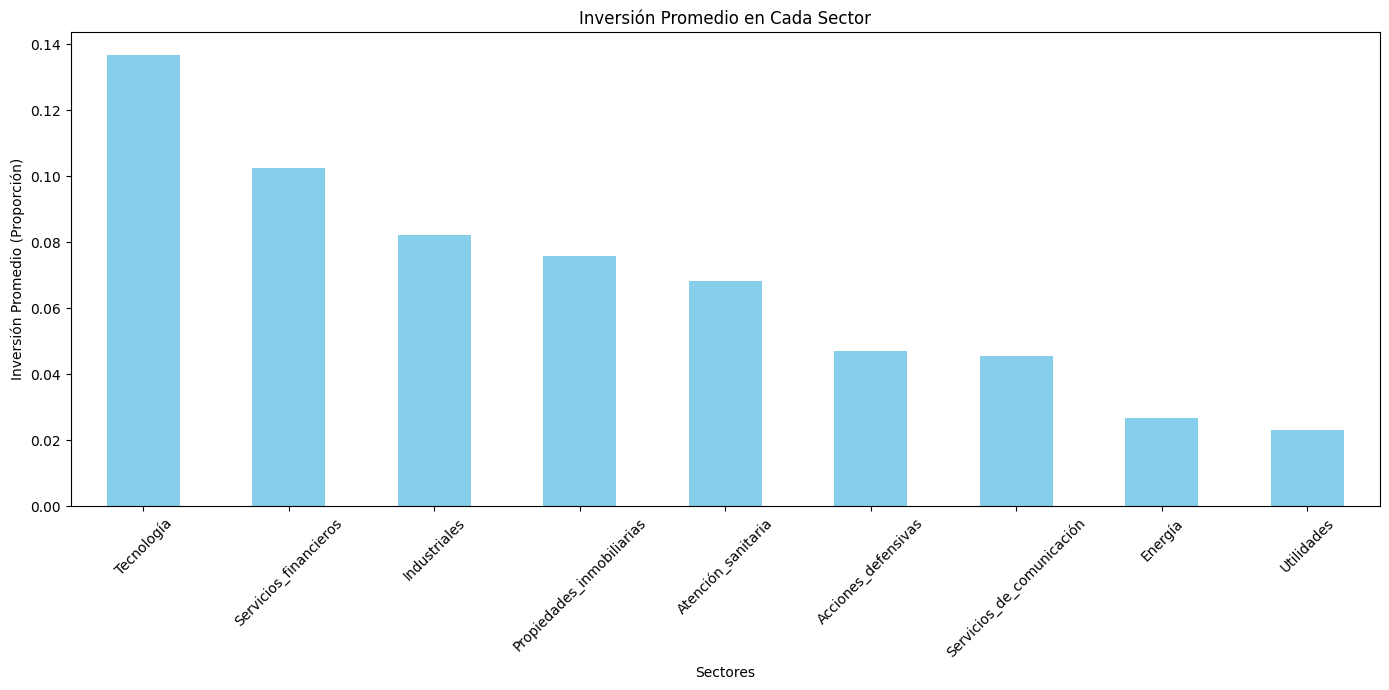

In [84]:
# Cálculo y selección
sector_columns = df_divsf_rend.columns[2:-3]
df_grafico_1 = df_divsf_rend[sector_columns].mean().sort_values(ascending=False)
# Visualización
plt.figure(figsize=(14,7))
df_grafico_1.plot(kind='bar', color='skyblue')
plt.title('Inversión Promedio en Cada Sector')
plt.xlabel('Sectores')
plt.ylabel('Inversión Promedio (Proporción)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Determinar el umbral para los ETFs más rentables (el cuartil superior)

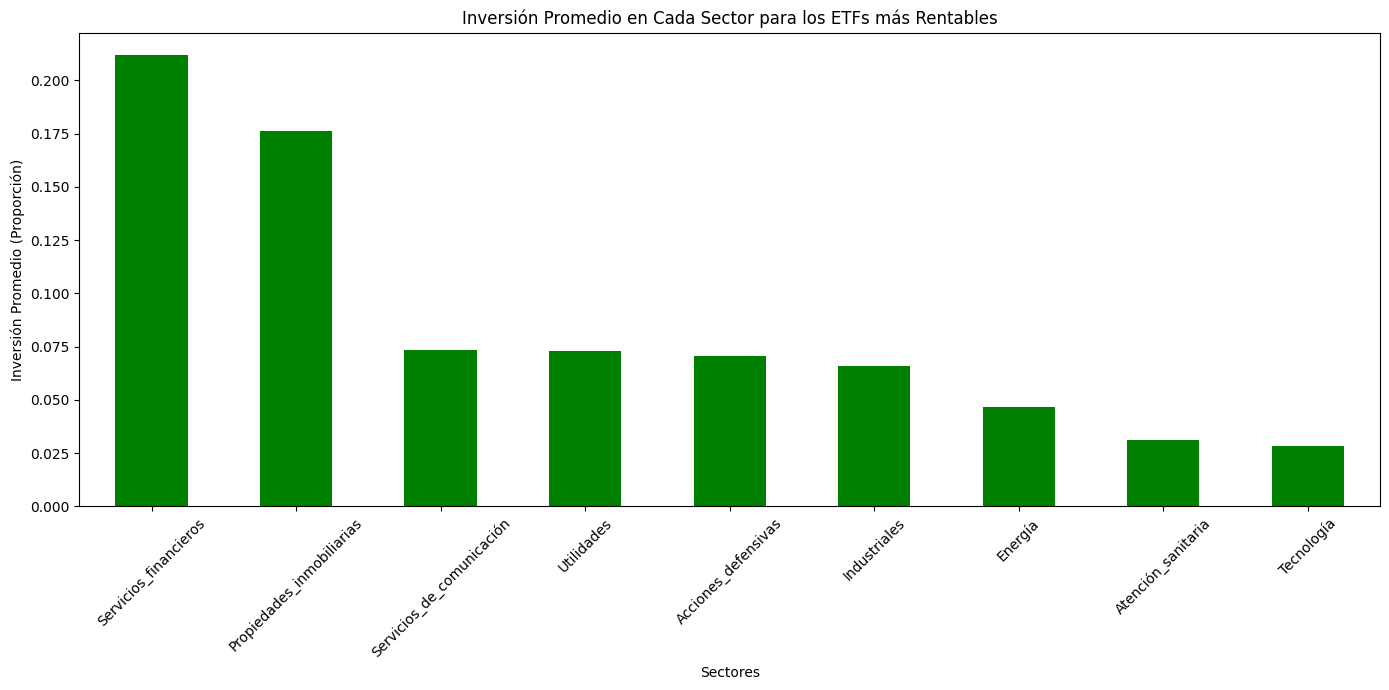

In [85]:
quantil_rentabilidad = df_divsf_rend['Rentabilidad'].quantile(0.75)
etfs_mas_rentables = df_divsf_rend[df_divsf_rend['Rentabilidad'] >= quantil_rentabilidad]
# Calcular
df_grafico_2 = etfs_mas_rentables[sector_columns].mean().sort_values(ascending=False)
# Visualizar
plt.figure(figsize=(14,7))
df_grafico_2.plot(kind='bar', color='green')
plt.title('Inversión Promedio en Cada Sector para los ETFs más Rentables')
plt.xlabel('Sectores')
plt.ylabel('Inversión Promedio (Proporción)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Top rentabilidad-riesgo ETFs

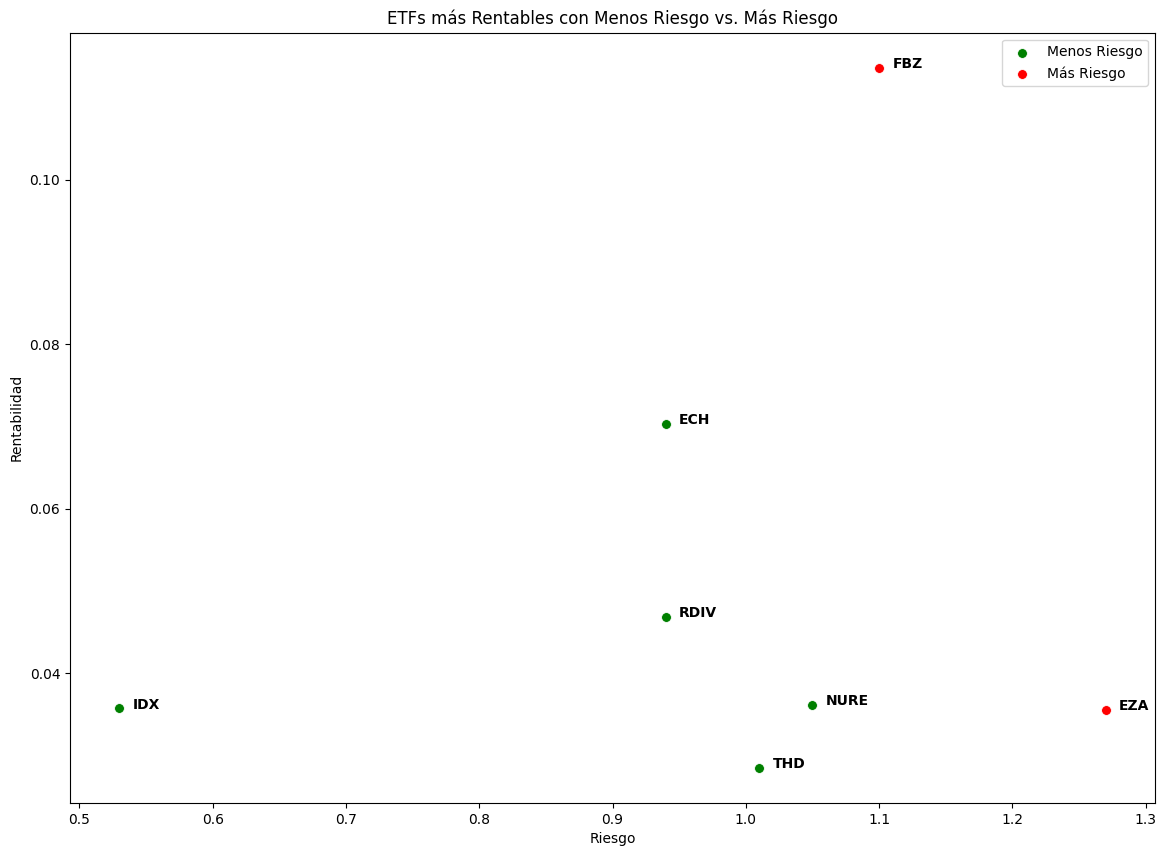

In [88]:
# Selección ETFs
riesgo_media = df_divsf_rend['Riesgo'].mean()
etfs_rentables_menos_riesgo = etfs_mas_rentables[etfs_mas_rentables['Riesgo'] <= riesgo_mediana]
etfs_rentables_mas_riesgo = etfs_mas_rentables[etfs_mas_rentables['Riesgo'] > riesgo_mediana]
etfs_rentables_menos_riesgo_sorted = etfs_rentables_menos_riesgo.sort_values(by=['Rentabilidad', 'Riesgo'], ascending=[False, True])
etfs_rentables_mas_riesgo_sorted = etfs_rentables_mas_riesgo.sort_values(by=['Rentabilidad', 'Riesgo'], ascending=[False, False])
etfs_rentables_menos_riesgo_sorted[['Ticker', 'Rentabilidad', 'Riesgo']], etfs_rentables_mas_riesgo_sorted[['Ticker', 'Rentabilidad', 'Riesgo']]

# Visualizar
plt.figure(figsize=(14,10))
sns.scatterplot(
    data=etfs_rentables_menos_riesgo_sorted,
    x='Riesgo', 
    y='Rentabilidad', 
    color='green', 
    label='Menos Riesgo',
    s=50
)
sns.scatterplot(
    data=etfs_rentables_mas_riesgo_sorted,
    x='Riesgo', 
    y='Rentabilidad', 
    color='red', 
    label='Más Riesgo',
    s=50
)

# Anotaciones
for line in range(0, etfs_rentables_menos_riesgo_sorted.shape[0]):
    plt.text(
        etfs_rentables_menos_riesgo_sorted['Riesgo'].iloc[line]+0.01,
        etfs_rentables_menos_riesgo_sorted['Rentabilidad'].iloc[line],
        etfs_rentables_menos_riesgo_sorted['Ticker'].iloc[line],
        horizontalalignment='left',
        size='medium',
        color='black',
        weight='semibold'
    )

for line in range(0, etfs_rentables_mas_riesgo_sorted.shape[0]):
    plt.text(
        etfs_rentables_mas_riesgo_sorted['Riesgo'].iloc[line]+0.01,
        etfs_rentables_mas_riesgo_sorted['Rentabilidad'].iloc[line],
        etfs_rentables_mas_riesgo_sorted['Ticker'].iloc[line],
        horizontalalignment='left',
        size='medium',
        color='black',
        weight='semibold'
    )

# Título y etiquetas
plt.title('ETFs más Rentables con Menos Riesgo vs. Más Riesgo')
plt.xlabel('Riesgo')
plt.ylabel('Rentabilidad')
plt.legend()

plt.show()

### Activos que más se repiten

In [89]:
air = airtable.Airtable(base_id=base_id, table_name='tblvxs74FGznyUCfL', api_key=api_key)
lista_de_diccionarios = air.get_all()
df_activos_repiten = lista_de_fields = [d['fields'] for d in lista_de_diccionarios]
df_activos_repiten = pd.DataFrame(lista_de_fields)

In [ ]:
symbol_etf_count = df_activos_repiten.groupby('Symbol')['Ticker'].nunique()
symbol_etf_count_df = symbol_etf_count.reset_index()
symbol_etf_count_df.columns = ['Symbol', 'ETF_Count']
symbol_etf_count_df = symbol_etf_count_df.sort_values(by='ETF_Count', ascending=False)
symbol_etf_count_filtered_df = symbol_etf_count_df[symbol_etf_count_df['ETF_Count'] >= 2]
symbol_etf_count_filtered_df = symbol_etf_count_filtered_df.reset_index(drop=True)
# Agregar la ponderación según los activos netos
air = airtable.Airtable(base_id=base_id, table_name='tblvbY1n5rzmFyBqZ', api_key=api_key)
lista_de_diccionarios = air.get_all()
lista_de_fields = [d['fields'] for d in lista_de_diccionarios]
df_activos_netos = pd.DataFrame(lista_de_fields)
# Que no por el hecho de que se repita significa que están
# aportando mayor rentabilidad a los ETFs que invierten en él.